In [58]:
import glob
import os
import re
import datetime as dt
import fathon
from fathon import fathonUtils as fu
import numpy as np
import pandas as pd
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import euclidean
import scipy.signal as signal
from sklearn.linear_model import LinearRegression
from fastdtw import fastdtw
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import mplleaflet
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [33]:
load_clustering = True

# Load monthly CO$_2$ data

In [3]:
data_path = './data'
reload_path = './intermediate_saves'

In [4]:
class CO2File(object):
    
    def __init__(self, data_file):
        self.data_file = data_file
        
        with open(data_file, 'r') as f:
            first_line = f.readline().strip()
            self.header_lines = int(self.__get_field(first_line))
            
        with open(data_file, 'r') as f:
            lines = f.readlines()
            self.header = [l.strip() for i, l in enumerate(lines) if i < self.header_lines]
            
    def __get_field(self, string):
        return string.split(':')[-1].strip()
    
    def get_id(self):
        s = list(filter(lambda v: re.match('^#\s+site_gaw_id\s+:.*$', v), self.header))[0]
        return self.__get_field(s)
    
    def get_name(self):
        s = list(filter(lambda v: re.match('^#\s+site_name\s+:.*$', v), self.header))[0]
        return self.__get_field(s)
    
    def get_country(self):
        s = list(filter(lambda v: re.match('^#\s+site_country/territory\s+:.*$', v), self.header))[0]
        return self.__get_field(s)
    
    def get_latitude(self):
        s = list(filter(lambda v: re.match('^#\s+site_latitude\s+:.*$', v), self.header))[0]
        return float(self.__get_field(s))
    
    def get_longitude(self):
        s = list(filter(lambda v: re.match('^#\s+site_longitude\s+:.*$', v), self.header))[0]
        return float(self.__get_field(s))
    
    def get_elevation(self):
        s = list(filter(lambda v: re.match('^#\s+site_elevation\s+:.*$', v), self.header))[0]
        return float(self.__get_field(s))
    
    def get_elevation_unit(self):
        s = list(filter(lambda v: re.match('^#\s+site_elevation_unit\s+:.*$', v), self.header))[0]
        return self.__get_field(s)
    
    def __get_co2_nan(self):
        s = list(filter(lambda v: re.match('^#\s+value:_FillValue\s+:.*$', v), self.header))[0]
        return float(self.__get_field(s))
    
    def get_co2_units(self):
        s = list(filter(lambda v: re.match('^#\s+value:units\s+:.*$', v), self.header))[0]
        return self.__get_field(s)
    
    def __get_co2_std_nan(self):
        s = list(filter(lambda v: re.match('^#\s+value_unc:_FillValue\s+:.*$', v), self.header))[0]
        return float(self.__get_field(s))
    
    def __get_flag_nan(self):
        s = list(filter(lambda v: re.match('^#\s+ORG_QCflag:_FillValue\s+:.*$', v), self.header))[0]
        return float(self.__get_field(s))
    
    def __substitute_dup_occurrences(self, string):
        idx = [m.start() for m in re.finditer(string, self.header[-1])][1]
        self.header[-1] = (self.header[-1][:idx] + string[0] + string[-1] + '2' +
                           self.header[-1][idx + len(string):])
        
    def get_start_and_end_dates(self):
        with open(self.data_file, 'r') as f:
            lines = f.readlines()
            first_data = lines[self.header_lines]
            last_data = lines[-1]
        fl = first_data.split()
        first_date = dt.datetime(int(fl[1]), int(fl[2]), 1, 0, 0, 0)
        ll = last_data.split()
        last_date = dt.datetime(int(ll[1]), int(ll[2]), 1, 0, 0, 0)
        return first_date, last_date
    
    def get_co2_data(self, start, end):
        self.__substitute_dup_occurrences('year')
        self.__substitute_dup_occurrences('month')
        self.__substitute_dup_occurrences('day')
        self.__substitute_dup_occurrences('hour')
        self.__substitute_dup_occurrences('minute')
        self.__substitute_dup_occurrences('second')
        df = pd.read_csv(self.data_file, header=self.header_lines, delimiter=' +',
                         names=self.header[-1].split()[1:], engine='python')
        # set nan values
        co2_nan = self.__get_co2_nan()
        co2_std_nan = self.__get_co2_std_nan()
        df.value.replace(co2_nan, np.nan, inplace=True)
        df.value_unc.replace(co2_std_nan, np.nan, inplace=True)
        not_valid_idxs = ((df.ORG_QCflag != '.') & (df.ORG_QCflag != '...') &
                          (df.ORG_QCflag != self.__get_flag_nan()))
        df.loc[not_valid_idxs, 'value'] = np.nan
        df.loc[not_valid_idxs, 'value_unc'] = np.nan
        # monthly date as index
        df['date'] = df.apply(lambda row: dt.datetime(int(row['year']), int(row['month']),
                                                      1, 0, 0, 0), axis=1)
        df.index = df.date
        cols_to_keep = ['value', 'value_unc']
        df.drop(df.columns.difference(cols_to_keep), axis=1, inplace=True)
        
        full_dates = pd.Series(pd.date_range(start=start, end=end, freq='MS'), name='date')
        new_df = pd.DataFrame(np.ones((len(full_dates), len(df.columns))) * np.nan,
                              columns=df.columns, index=full_dates)
        new_df.loc[df.index] = df
        
        return new_df

In [5]:
date_bounds = [CO2File(co2_file).get_start_and_end_dates()
               for co2_file in glob.glob(os.path.join(data_path, '*.txt'))]
min_date = np.min([d[0] for d in date_bounds])
max_date = np.max([d[1] for d in date_bounds])

In [6]:
co2_data = {}
for co2_file in glob.glob(os.path.join(data_path, '*.txt')):
    file_manager = CO2File(co2_file)
    co2_data[file_manager.get_id()] = {}
    co2_data[file_manager.get_id()]['name'] = file_manager.get_name()
    co2_data[file_manager.get_id()]['country'] = file_manager.get_country()
    co2_data[file_manager.get_id()]['latitude'] = file_manager.get_latitude()
    co2_data[file_manager.get_id()]['longitude'] = file_manager.get_longitude()
    co2_data[file_manager.get_id()]['elevation'] = file_manager.get_elevation()
    co2_data[file_manager.get_id()]['elevation_unit'] = file_manager.get_elevation_unit()
    co2_data[file_manager.get_id()]['co2_units'] = file_manager.get_co2_units()
    co2_data[file_manager.get_id()]['data'] = file_manager.get_co2_data(min_date, max_date)

# Data info

In [7]:
data_info = [[k, co2_data[k]['name'], co2_data[k]['country'], co2_data[k]['latitude'], co2_data[k]['longitude'],
              '{:.2f} {}'.format(co2_data[k]['elevation'], co2_data[k]['elevation_unit']),
              co2_data[k]['co2_units'], co2_data[k]['data'].value.dropna().index[0],
              co2_data[k]['data'].value.dropna().index[-1]] for k in co2_data.keys()]
info_table = pd.DataFrame(data_info, columns=['Id', 'Name', 'Country', 'Latitude', 'Longitude',
                                              'Elevation', 'Units', 'Start', 'End'])
info_table.sort_values(by='Latitude', ascending=False, inplace=True, ignore_index=True)

In [8]:
info_table

Id                            Name  \
0   ALT                           Alert   
1   ZEP  Zeppelin Mountain (Ny Ålesund)   
2   SUM                          Summit   
3   BRW                     Barrow (AK)   
4   TER                       Teriberka   
5   PAL                          Pallas   
6   MHD                       Mace Head   
7   SHM                   Shemya Island   
8   HPB                Hohenpeissenberg   
9   HUN                      Hegyhatsal   
10  UUM                       Ulaan Uul   
11  NWR        Niwot Ridge - T-van (CO)   
12  UTA                   Wendover (UT)   
13  TAP               Tae-ahn Peninsula   
14  SGP  Southern Great Plains E13 (OK)   
15  WLG                    Mt. Waliguan   
16  LMP                       Lampedusa   
17  BMW            Tudor Hill (Bermuda)   
18  WIS                      Sede Boker   
19  IZO                Izaña (Tenerife)   
20  MID                     Sand Island   
21  KEY                Key Biscane (FL)   
22  LLN                           Lulin   
23  ASK                        Assekrem   
24  MLO                  Mauna Loa (HI)   
25  KUM              Cape Kumukahi (HI)   
26  RPB                    Ragged Point   
27  SEY                            Mahé   
28  ASC                Ascension Island   
29  SMO           Samoa (Cape Matatula)   
30  CFA                   Cape Ferguson   
31  CGO                       Cape Grim   
32  BHD                     Baring Head   
33  CRZ                          Crozet   
34  MQA                Macquarie Island   
35  PSA                  Palmer Station   
36  CYA                           Casey   
37  SYO                           Syowa   
38  SPO                      South Pole   

                                              Country   Latitude   Longitude  \
0                                              Canada  82.499146  -62.341526   
1                                              Norway  78.906688   11.889342   
2                                             Denmark  72.580002  -38.480000   
3                            United States of America  71.323013 -156.611465   
4                                  Russian Federation  69.199997   35.099998   
5                                             Finland  67.973610   24.115833   
6                                             Ireland  53.326614   -9.904419   
7                            United States of America  52.720001  174.100006   
8                                             Germany  47.801498   11.009620   
9                                             Hungary  46.950001   16.650000   
10                                           Mongolia  44.444000  111.086100   
11                           United States of America  40.049999 -105.589996   
12                           United States of America  39.900002 -113.720001   
13                                  Republic of Korea  36.730000  126.129997   
14                           United States of America  36.599998  -97.500000   
15                                              China  36.287498  100.896301   
16                                              Italy  35.518200   12.630500   
17  United Kingdom of Great Britain and Northern I...  32.270000  -64.879997   
18                                             Israel  31.129999   34.880001   
19                                              Spain  28.309000  -16.499399   
20                           United States of America  28.219999 -177.369995   
21                           United States of America  25.666666  -80.199997   
22                          Taiwan, Province of China  23.469999  120.870003   
23                                            Algeria  23.266666    5.633333   
24                           United States of America  19.536230 -155.576157   
25                           United States of America  19.520000 -154.820007   
26                                           Barbados  13.170000  -59.430000   
27                                         S

<font size='4'>Percentage of missing values in each time series:</font>

In [9]:
nan_vals = {}
for i, k in enumerate(co2_data.keys()):
    nan_vals[k] = co2_data[k]['data'].value.isna().sum() / len(co2_data[k]['data']) * 100

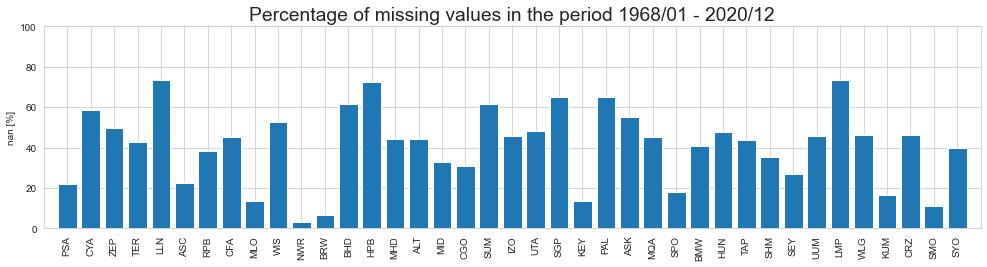

In [10]:
x = np.arange(0, len(list(nan_vals.values())))

fig, ax = plt.subplots(figsize=(14, 4))
plt.rcParams.update({'font.size': 16})
plt.bar(x, list(nan_vals.values()), width=0.8, align='center')
plt.xticks(x, list(nan_vals.keys()), rotation='vertical')
plt.xlim(x[0] - 1, x[-1] + 1)
plt.ylim(0, 100)
plt.ylabel('nan [%]')
plt.title('Percentage of missing values in the period {} - {}'.format(min_date.strftime('%Y/%m'),
                                                                      max_date.strftime('%Y/%m')))
plt.tight_layout()

<font size='4'>Periods of data availability:</font>

In [11]:
# set useful variables
value = 1
co2_max_len = np.max([len(co2_data[k]['data']) for k in co2_data.keys()])
dates_range = [d.strftime('%Y-%m') for d in pd.date_range(start=min_date, end=max_date, freq='MS')]

In [12]:
mtx = np.zeros((len(co2_data.keys()), co2_max_len), dtype=int)
stations = []
for i, station in enumerate(co2_data.keys()):
    co2 = co2_data[station]['data'].value.values[::-1]
    not_nans = np.where(~np.isnan(co2))
    mtx[i, not_nans] = value
    mtx[i, :] = mtx[i, ::-1]
    stations.append(station)

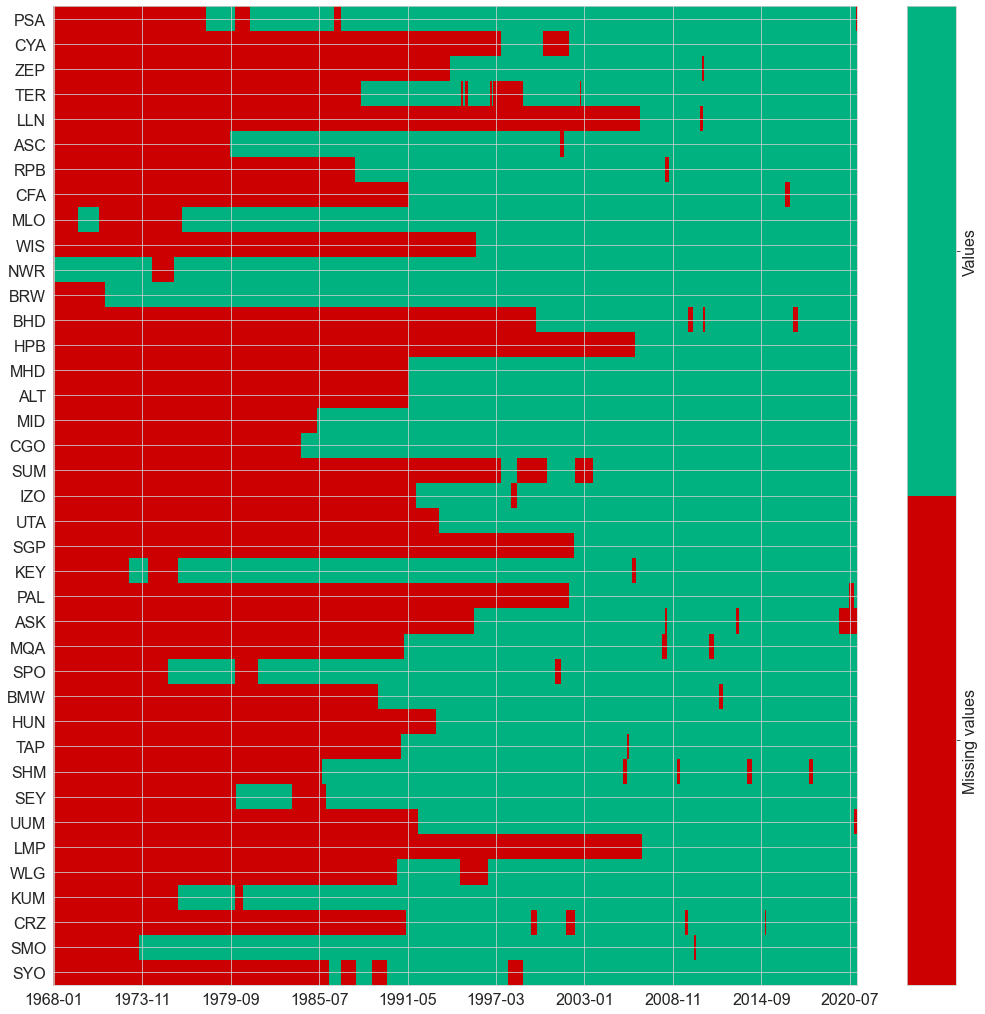

In [13]:
colors = [(0.8, 0, 0), (0, 0.7, 0.5)]
cmap_name = 'custom_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=2)
dates_step = 70

fig, ax = plt.subplots(figsize=(18, 18))
im = ax.imshow(mtx, aspect='auto', interpolation='none', cmap=cm)
ax.set_yticks(range(len(co2_data.keys())))
ax.set_yticklabels(stations)
ax.set_xticks(np.arange(len(dates_range), step=dates_step, dtype=int))
ax.set_xticklabels(dates_range[::dates_step])
cbar = fig.colorbar(im, ticks=[1/4, 3/4])
cbar.ax.set_yticklabels(['Missing values', 'Values'], rotation=90, va='center')
plt.show()

<font size='4'>CO$_2$ time series plots:</font>

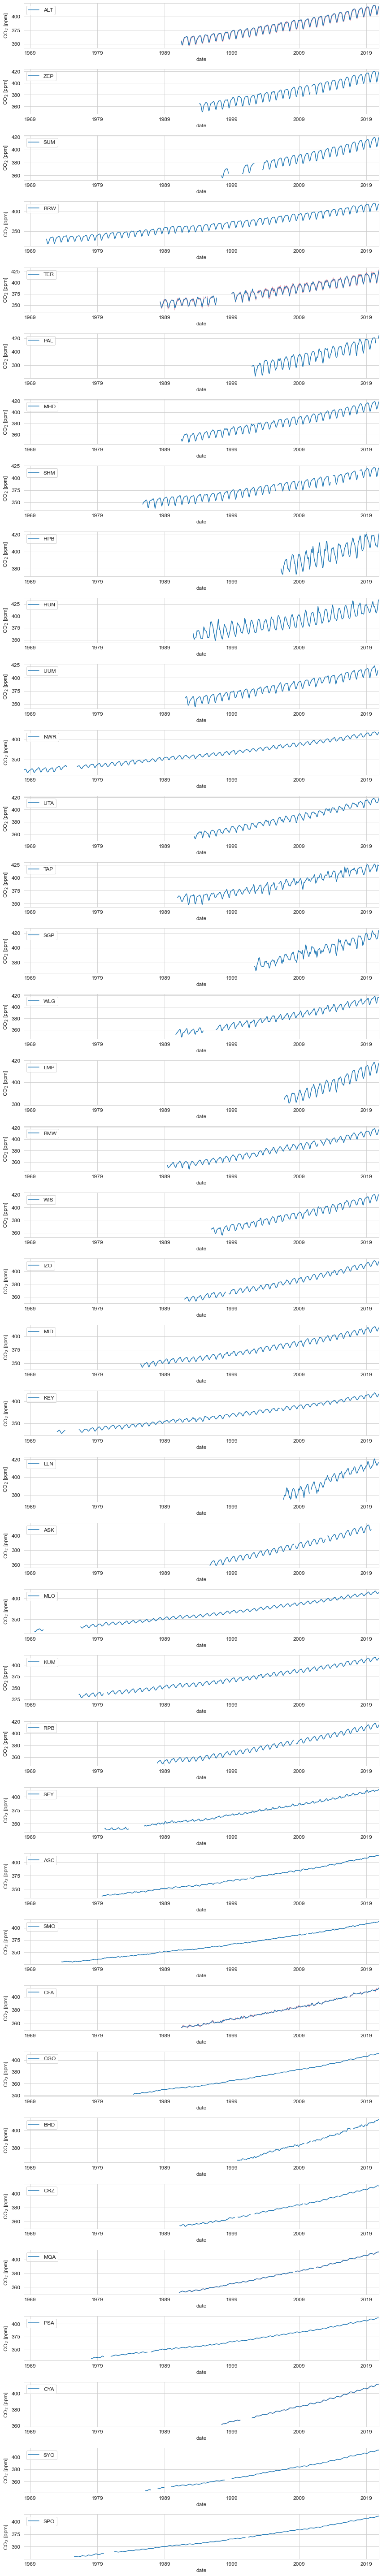

In [14]:
fig = plt.figure(figsize=(12, 80))
plt.rcParams.update({'font.size': 12})

cols = 1
rows = len(co2_data.keys())
for i, st_id in enumerate(info_table.Id.values):
    plt.subplot(rows, cols, i + 1)
    co2_data[st_id]['data'].value.plot(label=st_id)
    h_unc = co2_data[st_id]['data'].value.values + co2_data[st_id]['data'].value_unc.values
    l_unc = co2_data[st_id]['data'].value.values - co2_data[st_id]['data'].value_unc.values
    plt.fill_between(co2_data[st_id]['data'].index, h_unc, l_unc, color="crimson", alpha=0.3)
    plt.ylabel('CO$_2$ [{}]'.format(co2_data[st_id]['co2_units']))
    plt.legend(loc=2)

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()

<font size='4'>Location of the sites on a map:</font>

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))
for k in co2_data.keys():
    if co2_data[k]['latitude'] > 0:
        color = 'b'
    else:
        color = 'r'
    plt.scatter(co2_data[k]['longitude'], co2_data[k]['latitude'], c=color, marker='o', s=30)
mplleaflet.display(fig=fig)

/opt/anaconda3/envs/fathon-env/lib/python3.8/site-packages/mplleaflet/mplexporter/exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
/opt/anaconda3/envs/fathon-env/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Clustering

In [16]:
def DTWDistance(ts1, ts2):
    d, p = fastdtw(ts1, ts2, dist=euclidean)
    return d

### Each time series with its own length

In [17]:
clust_file = 'DTWDistance_complete.txt'
if load_clustering:
    Z = np.loadtxt(os.path.join(reload_path, clust_file))
else:
    Z = linkage(mtx, metric=DTWDistance, method='complete')
    np.savetxt(os.path.join(reload_path, clust_file), Z)

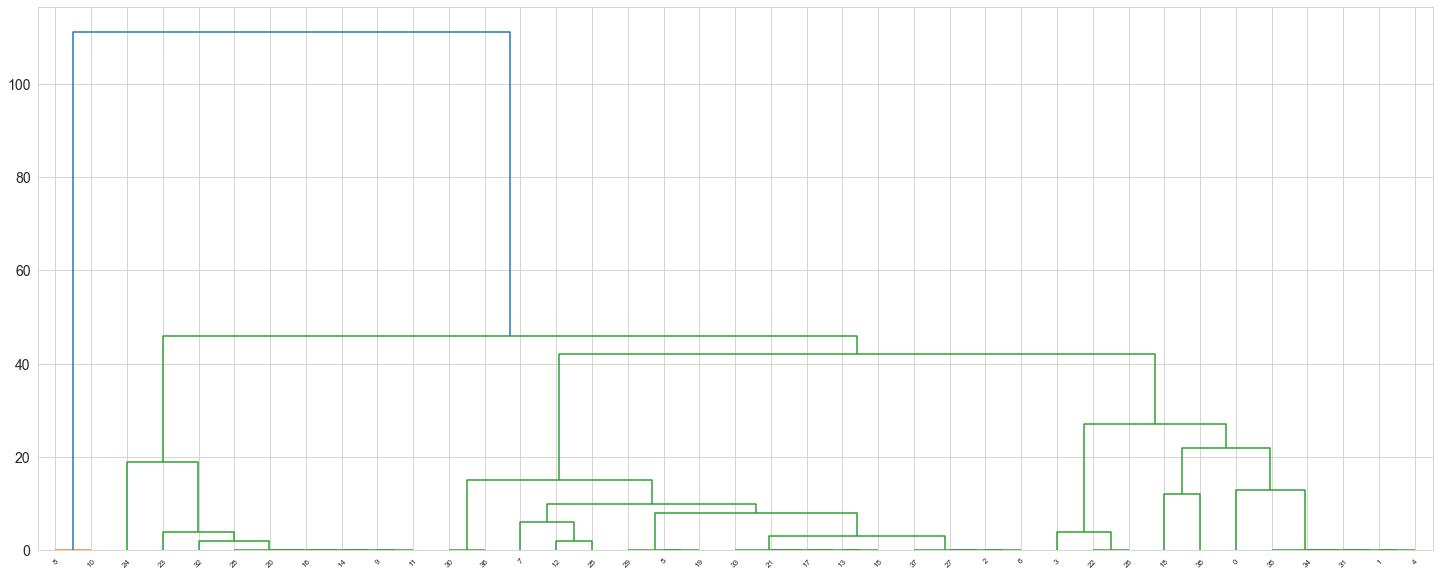

In [18]:
plt.figure(figsize=(25, 10))
plt.rcParams.update({'font.size': 14})
dendrogram(Z)
plt.show()

In [19]:
clusters = fcluster(Z, 40, criterion='distance')

In [20]:
clust_dict = {}
n_clust = np.max(clusters)
print('{:d} clusters have been found.'.format(n_clust))

for i in range(1, n_clust + 1):
    clust_dict[i] = []
    
for i, clust_num in enumerate(clusters):
    clust_dict[clust_num].append(stations[i])

4 clusters have been found.


<font size='4'>Clusters division:</font>

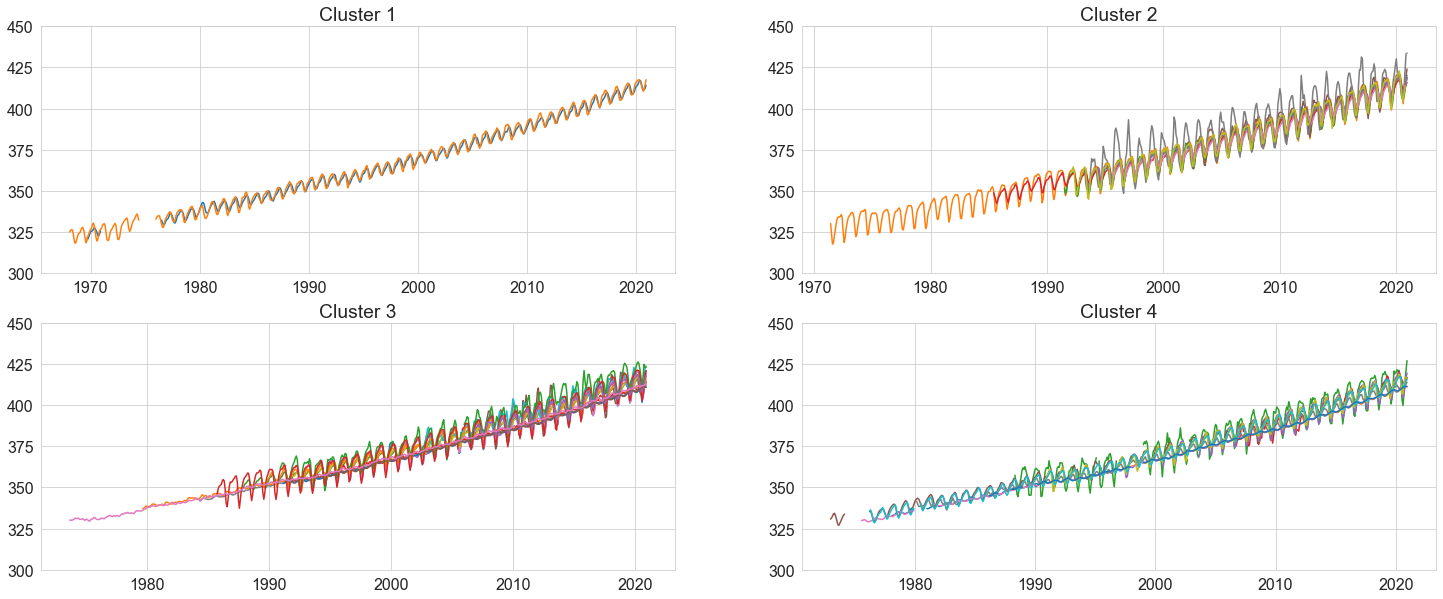

In [21]:
plt.figure(figsize=(25, 10))
plt.rcParams.update({'font.size': 16})
for i in range(len(clust_dict)):
    plt.subplot(int(len(clust_dict) / 2) + len(clust_dict) % 2, 2, i + 1)
    for st_id in clust_dict[i + 1]:
        plt.plot(co2_data[st_id]['data'].index, co2_data[st_id]['data'].value)
        plt.title('Cluster {:d}'.format(i + 1))
        plt.ylim(300, 450)

<font size='4'>Location of the clusters on a map:</font>

In [22]:
colors = ['b', 'r', 'g', 'y']
shapes = ['o', '^', 's', '*']

fig, ax = plt.subplots(figsize=(12, 12))
for k in clust_dict.keys():
    c, m = colors[k - 1], shapes[k - 1]
    for i in clust_dict[k]:
        plt.scatter(co2_data[i]['longitude'], co2_data[i]['latitude'], c=c, marker=m, s=30)
mplleaflet.display(fig=fig)

/opt/anaconda3/envs/fathon-env/lib/python3.8/site-packages/mplleaflet/mplexporter/exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
/opt/anaconda3/envs/fathon-env/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<font size='4'>Clusters does not seem to separate time series well.</font>

### Equal lengths

In [23]:
mtx_ol = mtx.copy()
max_min_date = np.max([d[0] for d in date_bounds])
min_max_date = np.min([d[1] for d in date_bounds])

i0 = np.where(np.array(dates_range, dtype=str) == max_min_date.strftime('%Y-%m'))[0][0]
i1 = np.where(np.array(dates_range, dtype=str) == min_max_date.strftime('%Y-%m'))[0][0]

mtx_ol = mtx_ol[:, i0:i1 + 1]

In [24]:
clust_file = 'DTWDistance_complete_same_lenght.txt'
if load_clustering:
    Z = np.loadtxt(os.path.join(reload_path, clust_file))
else:
    Z = linkage(mtx_ol, metric=DTWDistance, method='complete')
    np.savetxt(os.path.join(reload_path, clust_file), Z)

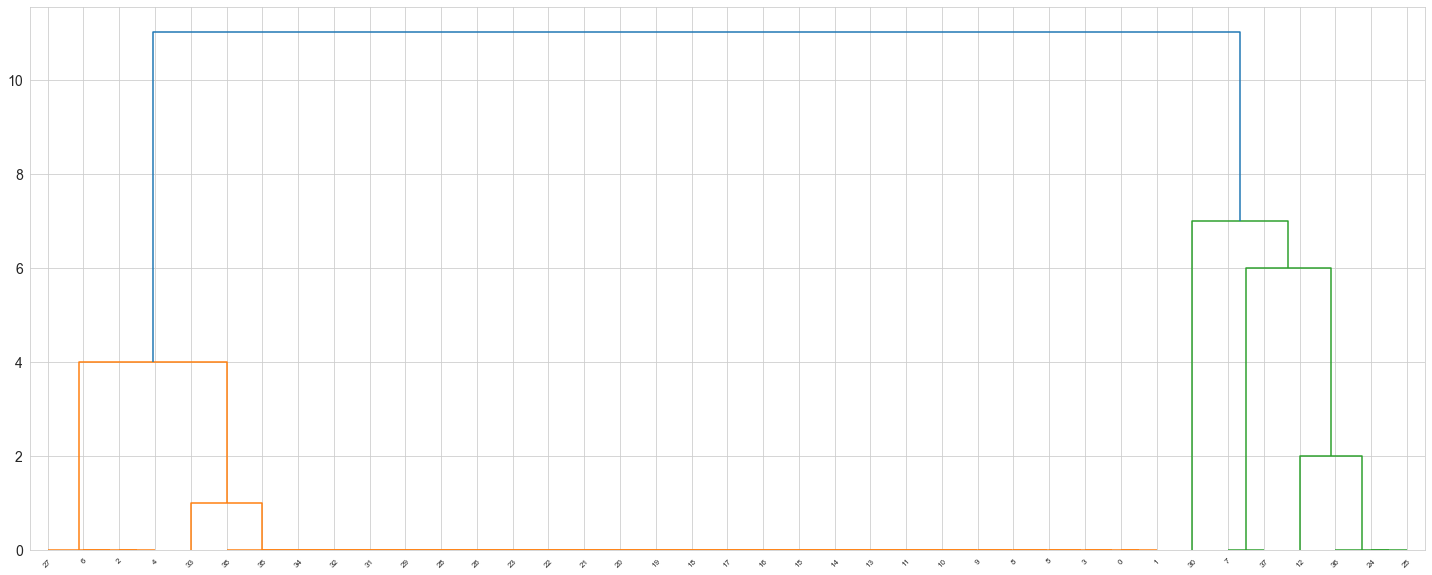

In [25]:
plt.figure(figsize=(25, 10))
plt.rcParams.update({'font.size': 14})
dendrogram(Z)
plt.show()

In [26]:
clusters = fcluster(Z, 8, criterion='distance')

In [27]:
clust_dict = {}
n_clust = np.max(clusters)
print('{:d} clusters have been found.'.format(n_clust))

for i in range(1, n_clust + 1):
    clust_dict[i] = []
    
for i, clust_num in enumerate(clusters):
    clust_dict[clust_num].append(stations[i])

2 clusters have been found.


<font size='4'>Clusters division:</font>

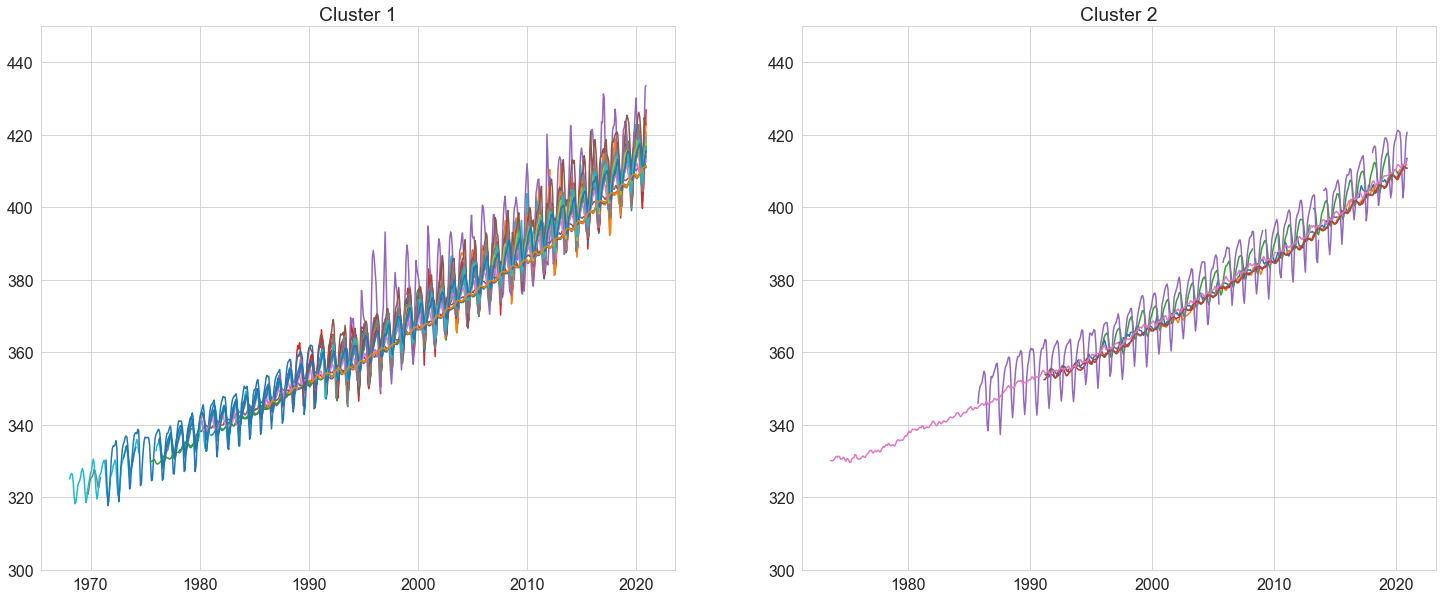

In [28]:
plt.figure(figsize=(25, 10))
plt.rcParams.update({'font.size': 16})
for i in range(len(clust_dict)):
    plt.subplot(int(len(clust_dict) / 2) + len(clust_dict) % 2, 2, i + 1)
    for st_id in clust_dict[i + 1]:
        plt.plot(co2_data[st_id]['data'].index, co2_data[st_id]['data'].value)
        plt.title('Cluster {:d}'.format(i + 1))
        plt.ylim(300, 450)

<font size='4'>Location of the clusters on a map:</font>

In [29]:
colors = ['b', 'r', 'g', 'y']
shapes = ['o', '^', 's', '*']

fig, ax = plt.subplots(figsize=(12, 12))
for k in clust_dict.keys():
    c, m = colors[k - 1], shapes[k - 1]
    for i in clust_dict[k]:
        plt.scatter(co2_data[i]['longitude'], co2_data[i]['latitude'], c=c, marker=m, s=30)
mplleaflet.display(fig=fig)

/opt/anaconda3/envs/fathon-env/lib/python3.8/site-packages/mplleaflet/mplexporter/exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
/opt/anaconda3/envs/fathon-env/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<font size='4'>Clusters does not seem to separate time series well, not even with the same length.</font>

# DFA

In [45]:
def dfa(param, lims=None):
    dfa_data = co2_data[param]['data'].value.dropna().values
    min_scale = 4
    max_scale = len(dfa_data) // 4
    step_scale = 1
    if len(dfa_data) > 10 * step_scale:
        dfa = fathon.DFA(fu.toAggregated(dfa_data))
        dfa_scales = fu.linRangeByStep(min_scale, max_scale, step_scale)
        n, F = dfa.computeFlucVec(dfa_scales)
        if lims is None:
            H, I = dfa.fitFlucVec()
        else:
            H, I = dfa.fitFlucVec(nStart=lims[0], nEnd=lims[1])
    else:
        n = np.array([])
        F = np.array([])
        H = 0.0
        I = 0.0
    
    return n, F, H, I

<font size='4'>Try DFA without removing the periodic components:</font>

In [46]:
for k in co2_data.keys():
    n, F, H, I = dfa(k)
    co2_data[k]['n'] = n
    co2_data[k]['F'] = F
    co2_data[k]['H'] = H
    co2_data[k]['I'] = I

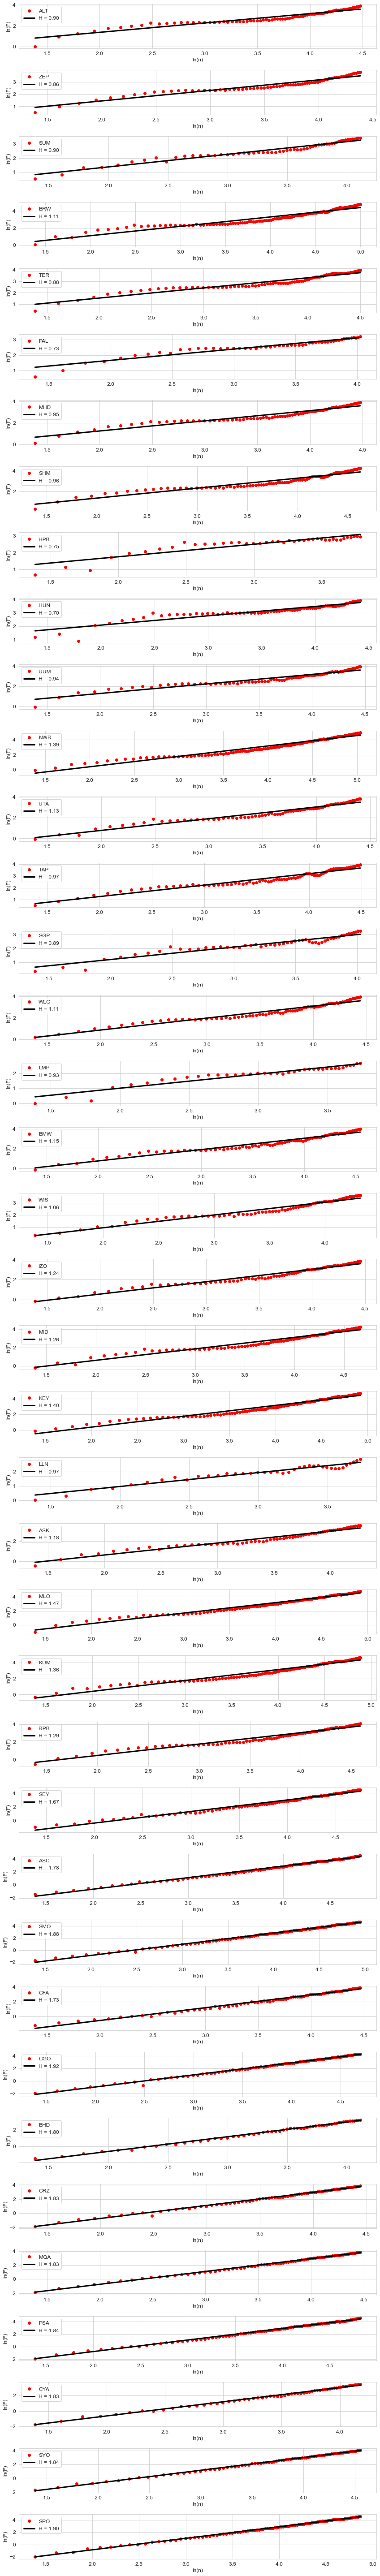

In [47]:
fig = plt.figure(figsize=(12, 80))
plt.rcParams.update({'font.size': 12})

cols = 1
rows = len(co2_data.keys())
for i, st_id in enumerate(info_table.Id.values):
    plt.subplot(rows, cols, i + 1)
    plt.plot(np.log(co2_data[st_id]['n']), np.log(co2_data[st_id]['F']), 'ro', label=st_id)
    plt.plot(np.log(co2_data[st_id]['n']),
             co2_data[st_id]['I'] + co2_data[st_id]['H'] * np.log(co2_data[st_id]['n']),
             'k-', linewidth=3, label='H = {:.2f}'.format(co2_data[st_id]['H']))
    plt.ylabel('ln(F)')
    plt.xlabel('ln(n)')
    plt.legend(loc=2)

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()

<font size='4'>
    <ul>
        <li>Black -> H in [0.5, 1.0)</li>
        <li>Magenta -> H in [1.0, 1.5)</li>
        <li>Red -> H in [1.5, 2.0]</li>
    </ul>
</font>

In [49]:
fig, ax = plt.subplots(figsize=(12, 12))
for k in co2_data.keys():
    if co2_data[k]['H'] < 1.0:
        c = 'k'
    elif co2_data[k]['H'] >= 1.0 and co2_data[k]['H'] < 1.5:
        c = 'm'
    else:
        c = 'r'
    plt.scatter(co2_data[k]['longitude'], co2_data[k]['latitude'], c=c, marker='o', s=30)
mplleaflet.display(fig=fig)

/opt/anaconda3/envs/fathon-env/lib/python3.8/site-packages/mplleaflet/mplexporter/exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
/opt/anaconda3/envs/fathon-env/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# MFDFA

In [54]:
q_list = np.arange(-5, 5, 0.3)

In [55]:
def mf_spect(param, lims=None):
    mfdfa_data = co2_data[param]['data'].value.dropna().values
    min_scale = 4
    max_scale = len(mfdfa_data) // 4
    step_scale = 1
    if len(mfdfa_data) > 10 * step_scale:
        mfdfa = fathon.MFDFA(fu.toAggregated(mfdfa_data))
        mfdfa_scales = fu.linRangeByStep(min_scale, max_scale, step_scale)
        n, F = mfdfa.computeFlucVec(mfdfa_scales, q_list)
        if lims is None:
            H, I = mfdfa.fitFlucVec()
        else:
            H, I = mfdfa.fitFlucVec(nStart=lims[0], nEnd=lims[1])
        a, f = mfdfa.computeMultifractalSpectrum()
    else:
        a = np.array([])
        f = np.array([])
        H = np.array([])
    
    return a, f, H

<font size='4'>Try MFDFA without removing the periodic components:</font>

In [51]:
for k in co2_data.keys():
    a, f, hq = mf_spect(k)
    co2_data[k]['a'] = a
    co2_data[k]['f'] = f
    co2_data[k]['hq'] = hq

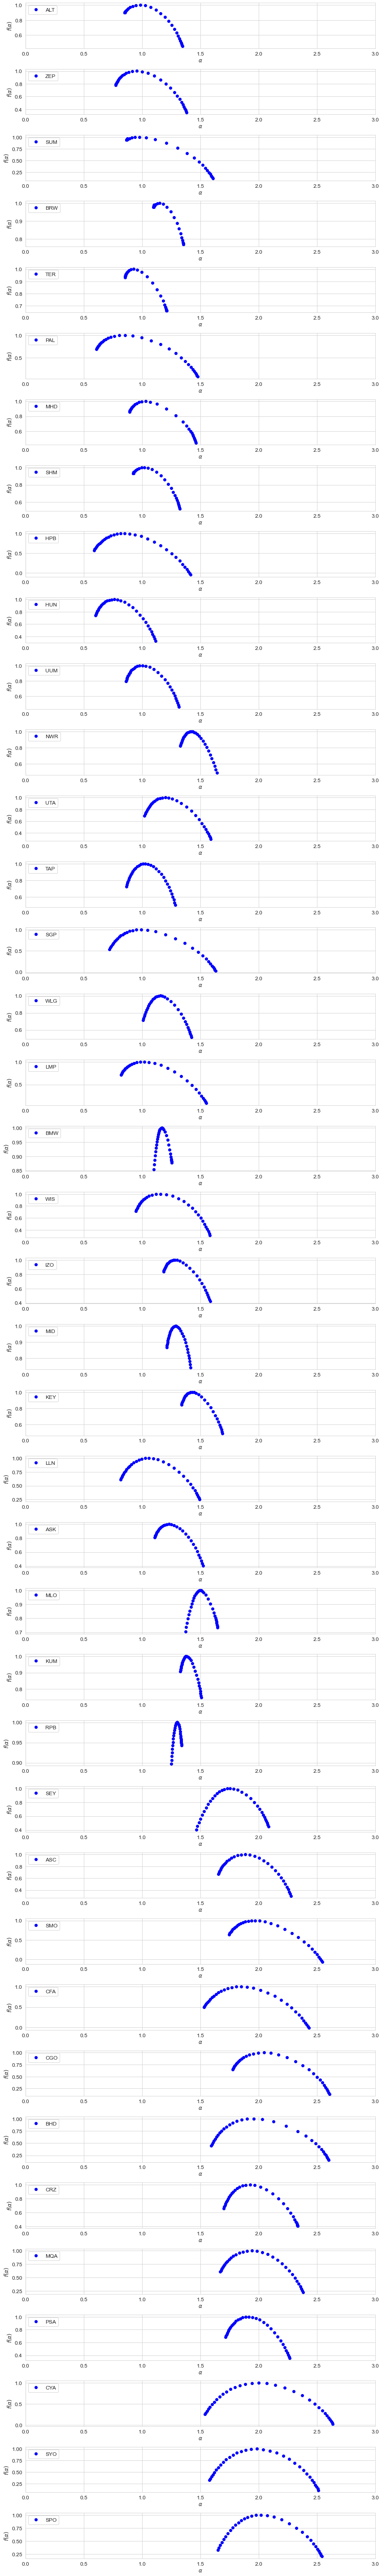

In [53]:
fig = plt.figure(figsize=(12, 80))
plt.rcParams.update({'font.size': 12})

cols = 1
rows = len(co2_data.keys())
for i, st_id in enumerate(info_table.Id.values):
    plt.subplot(rows, cols, i + 1)
    plt.plot(co2_data[st_id]['a'], co2_data[st_id]['f'], 'bo', label=st_id)
    plt.ylabel('$f(\\alpha)$')
    plt.xlabel('$\\alpha$')
    plt.legend(loc=2)
    plt.xlim(0, 3)

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()

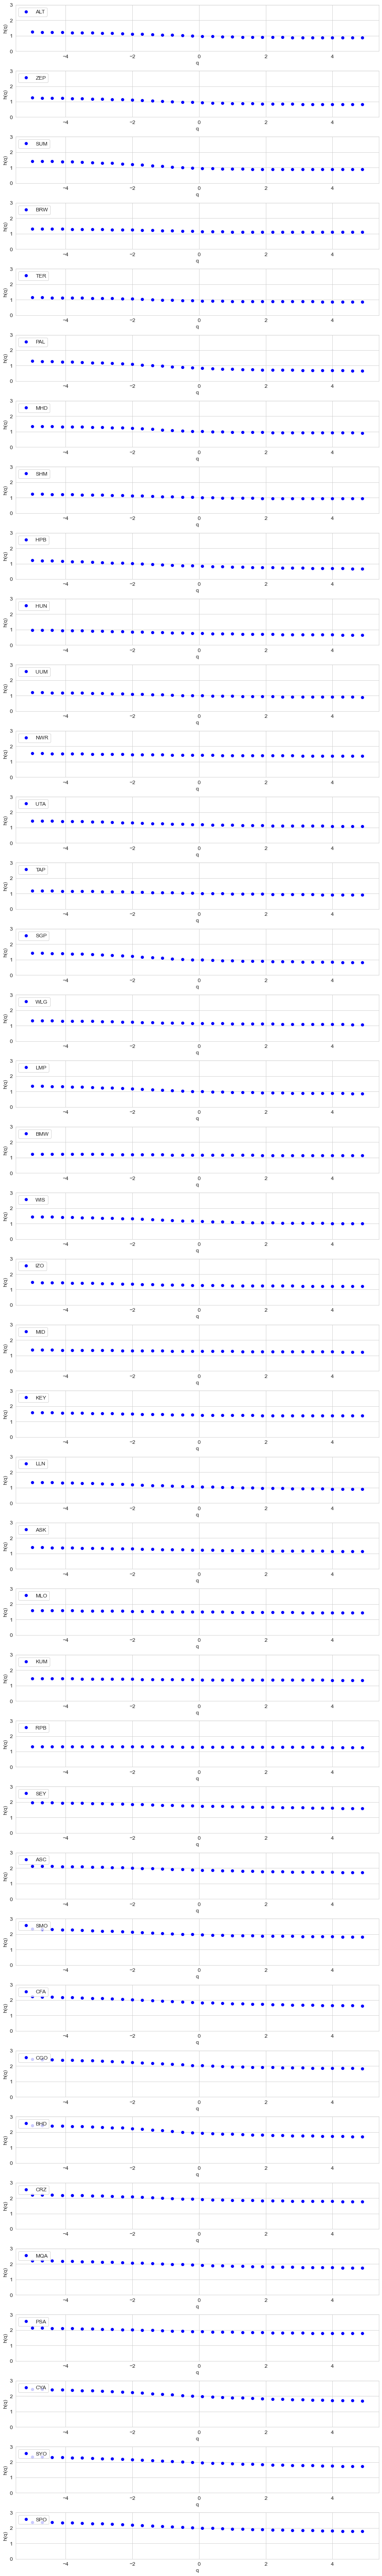

In [56]:
fig = plt.figure(figsize=(12, 80))
plt.rcParams.update({'font.size': 12})

cols = 1
rows = len(co2_data.keys())
for i, st_id in enumerate(info_table.Id.values):
    plt.subplot(rows, cols, i + 1)
    plt.plot(q_list, co2_data[st_id]['hq'], 'bo', label=st_id)
    plt.ylabel('h(q)')
    plt.xlabel('q')
    plt.legend(loc=2)
    plt.ylim(0, 3)

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()

# Trend

In [71]:
def fit_vars(param):
    t_fit = np.arange(0, len(co2_data[param]['data']))
    t_fit = t_fit[~np.isnan(co2_data[param]['data'].value)]
    t2_fit = t_fit ** 2

    t_fit = pd.Series(t_fit, index=co2_data[param]['data'].value.dropna().index)
    t2_fit = pd.Series(t2_fit, index=co2_data[param]['data'].value.dropna().index)

    fit_df = pd.concat([t_fit, t2_fit], axis=1)
    fit_df.columns = ['t', 't2']
    
    return fit_df

<font size='4'>Find trend from the series:</font>

In [72]:
for k in co2_data.keys():
    fit_df = fit_vars(k)
    lin_reg = LinearRegression()
    lin_reg.fit(fit_df, co2_data[k]['data'].value.dropna())
    co2_data[k]['data']['trend'] = lin_reg.intercept_ + fit_df.dot(lin_reg.coef_)

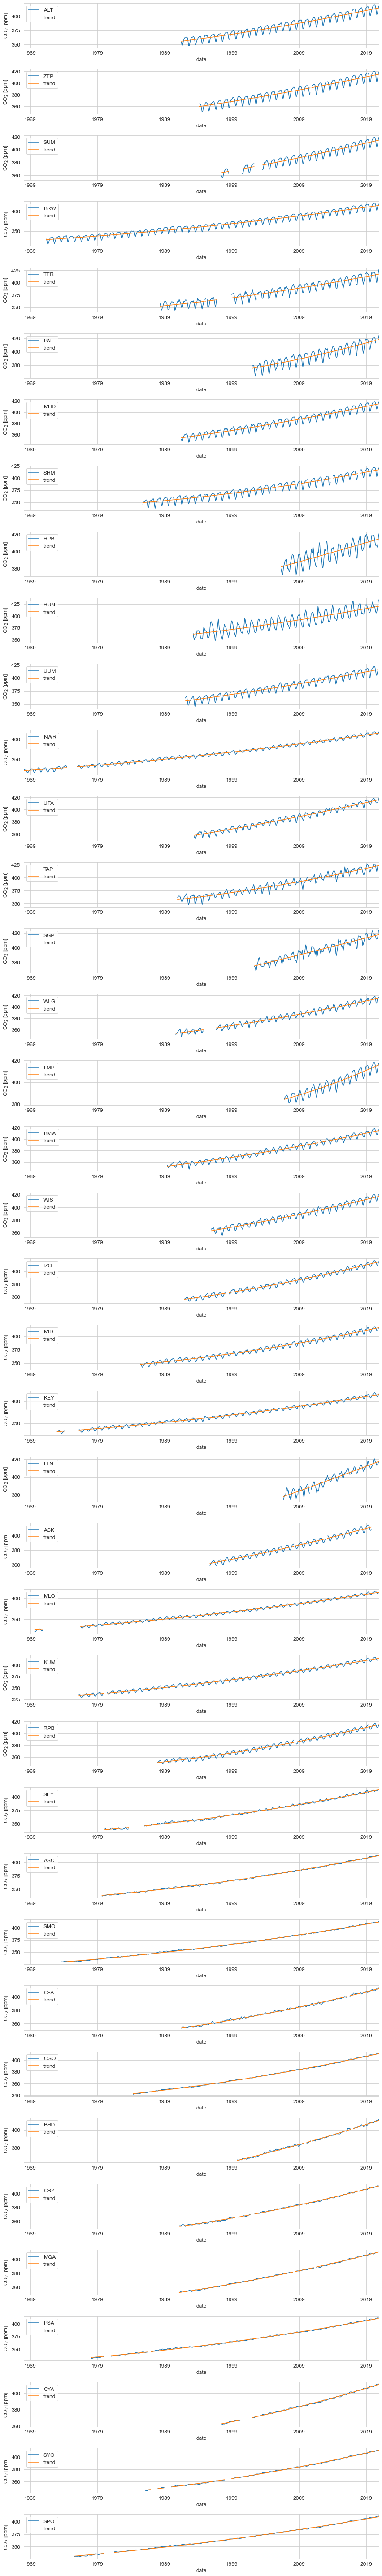

In [73]:
fig = plt.figure(figsize=(12, 80))
plt.rcParams.update({'font.size': 12})

cols = 1
rows = len(co2_data.keys())
for i, st_id in enumerate(info_table.Id.values):
    plt.subplot(rows, cols, i + 1)
    co2_data[st_id]['data'].value.plot(label=st_id)
    co2_data[st_id]['data'].trend.plot(label='trend')
    plt.ylabel('CO$_2$ [{}]'.format(co2_data[st_id]['co2_units']))
    plt.legend(loc=2)

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()

# Lomb spectrum

In [74]:
def lomb(ts, delta_t=1, ofac=1):
    if (len(ts) * ofac) % 2:
        freqs = 2 * np.pi * np.arange(1, np.floor(0.5 * len(ts) * ofac) + 1, dtype=int) / (len(ts) * delta_t * ofac)
    else:
        freqs = 2 * np.pi * np.arange(1, np.floor(0.5 * len(ts) * ofac), dtype=int) / (len(ts) * delta_t * ofac)
        
    t = np.arange(1, len(ts) + 1, delta_t, dtype=int)
    
    nan_idxs = np.where(~np.isnan(ts))
    ts = ts[nan_idxs]
    t = t[nan_idxs]

    pgram = signal.lombscargle(t, ts, freqs, normalize=True)
    
    return freqs, pgram

In [86]:
def fit_res_vars(param):
    t_fit = np.arange(0, len(co2_data[param]['data']))
    t_fit = t_fit[~np.isnan(co2_data[param]['data'].value)]
    t2_fit = t_fit ** 2
    if co2_data[param]['year_per'] == 1:
        year_sin = np.sin((2 * np.pi / 12) * t_fit)
        year_cos = np.cos((2 * np.pi / 12) * t_fit)
    if co2_data[param]['semi_per'] == 1:
        semi_sin = np.sin((2 * np.pi / 6) * t_fit)
        semi_cos = np.cos((2 * np.pi / 6) * t_fit)

    t_fit = pd.Series(t_fit, index=co2_data[param]['data'].value.dropna().index)
    t2_fit = pd.Series(t2_fit, index=co2_data[param]['data'].value.dropna().index)
    if co2_data[param]['year_per'] == 1:
        year_sin = pd.Series(year_sin, index=co2_data[param]['data'].value.dropna().index)
        year_cos = pd.Series(year_cos, index=co2_data[param]['data'].value.dropna().index)
    if co2_data[param]['semi_per'] == 1:
        semi_sin = pd.Series(semi_sin, index=co2_data[param]['data'].value.dropna().index)
        semi_cos = pd.Series(semi_cos, index=co2_data[param]['data'].value.dropna().index)
    

    fit_vars = [t_fit, t2_fit]
    cols = ['t', 't2']
    if co2_data[param]['year_per'] == 1:
        fit_vars.append(year_sin)
        cols.append('year_sin')
        fit_vars.append(year_cos)
        cols.append('year_cos')
    if co2_data[param]['semi_per'] == 1:
        fit_vars.append(semi_sin)
        cols.append('semi_sin')
        fit_vars.append(semi_cos)
        cols.append('semi_cos')
    
    fit_df = pd.concat(fit_vars, axis=1)
    fit_df.columns = cols
    
    return fit_df

<font size='4'>Find periodicities from spectrum and in case remove them:</font>

In [78]:
for k in co2_data.keys():
    lomb_data = co2_data[k]['data'].value.values - co2_data[k]['data'].trend.values
    omg, p_lomb = lomb(lomb_data, ofac=4, delta_t=1)
    co2_data[k]['omg'] = omg
    co2_data[k]['lomb'] = p_lomb
    
    co2_data[k]['year_per'] = 0
    co2_data[k]['semi_per'] = 0
    p_sorted = sorted(p_lomb, reverse=True)
    for i in range(20):
        max_idx = np.where(p_lomb == p_sorted[i])[0][0]
        per = 2 * np.pi / omg[max_idx]
        if per > 5 and per < 7:
            co2_data[k]['semi_per'] = 1
        elif per > 11 and per < 13:
            co2_data[k]['year_per'] = 1
            
        if co2_data[k]['semi_per'] == 1 and co2_data[k]['year_per'] == 1:
            break

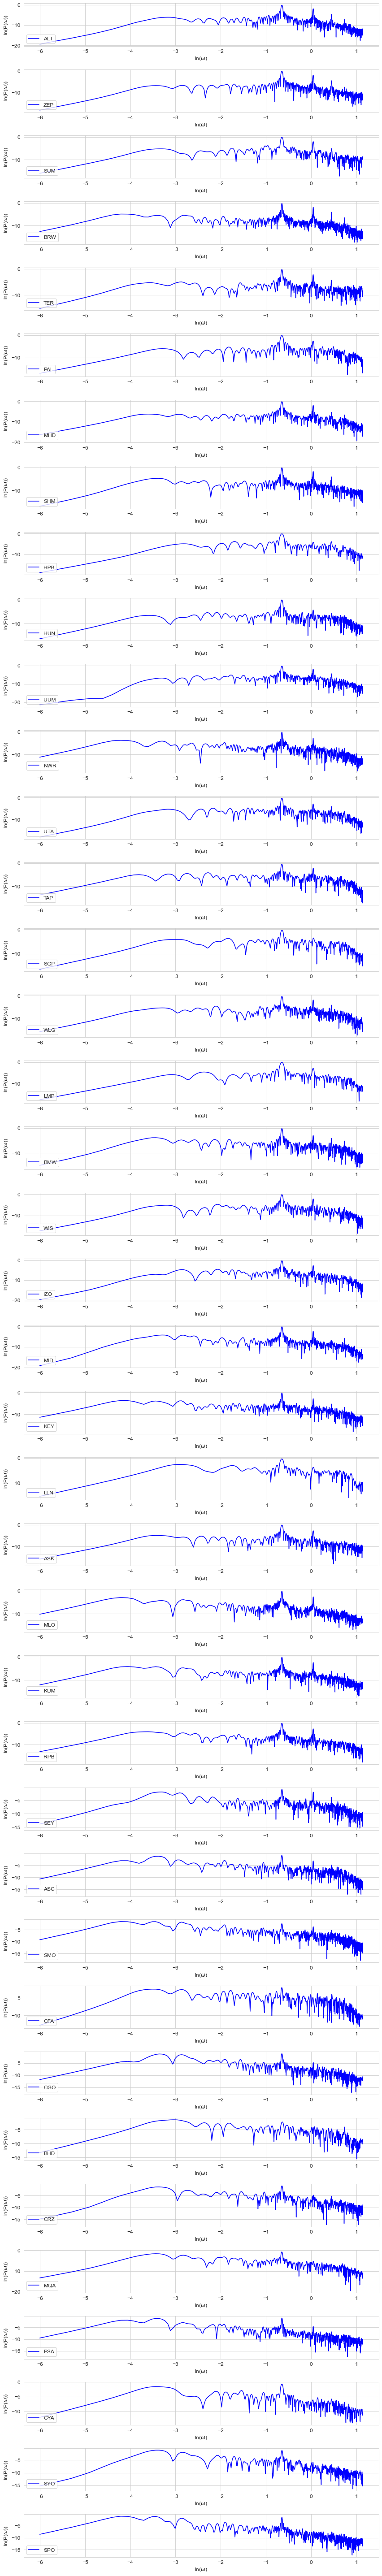

In [83]:
fig = plt.figure(figsize=(12, 80))
plt.rcParams.update({'font.size': 12})

cols = 1
rows = len(co2_data.keys())
for i, st_id in enumerate(info_table.Id.values):
    plt.subplot(rows, cols, i + 1)
    plt.plot(np.log(co2_data[st_id]['omg']), np.log(co2_data[st_id]['lomb']), 'b', label=st_id)
    plt.ylabel('ln(P($\omega$))')
    plt.xlabel('ln($\omega$)')
    plt.legend(loc=3)

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()

In [87]:
for k in co2_data.keys():
    fit_df = fit_res_vars(k)
    lin_reg = LinearRegression()
    lin_reg.fit(fit_df, co2_data[k]['data'].value.dropna())
    co2_data[k]['data']['res'] = co2_data[k]['data'].value - (lin_reg.intercept_ + fit_df.dot(lin_reg.coef_))

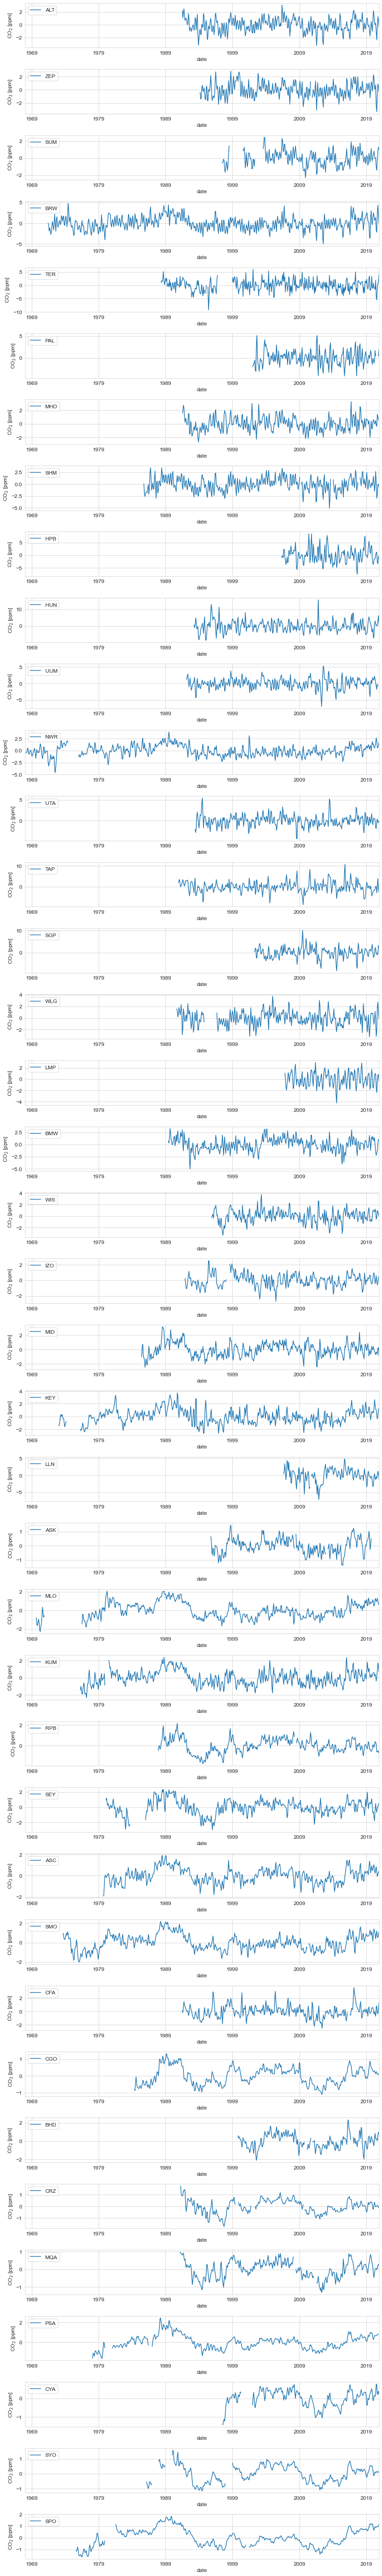

In [88]:
fig = plt.figure(figsize=(12, 80))
plt.rcParams.update({'font.size': 12})

cols = 1
rows = len(co2_data.keys())
for i, st_id in enumerate(info_table.Id.values):
    plt.subplot(rows, cols, i + 1)
    co2_data[st_id]['data'].res.plot(label=st_id)
    plt.ylabel('CO$_2$ [{}]'.format(co2_data[st_id]['co2_units']))
    plt.legend(loc=2)

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()

<font size='4'>Redo DFA and MFDFA for residuals:</font>

# DFA

In [89]:
def dfa_res(param, lims=None):
    dfa_data = co2_data[param]['data'].res.dropna().values
    min_scale = 4
    max_scale = len(dfa_data) // 4
    step_scale = 1
    if len(dfa_data) > 10 * step_scale:
        dfa = fathon.DFA(fu.toAggregated(dfa_data))
        dfa_scales = fu.linRangeByStep(min_scale, max_scale, step_scale)
        n, F = dfa.computeFlucVec(dfa_scales)
        if lims is None:
            H, I = dfa.fitFlucVec()
        else:
            H, I = dfa.fitFlucVec(nStart=lims[0], nEnd=lims[1])
    else:
        n = np.array([])
        F = np.array([])
        H = 0.0
        I = 0.0
    
    return n, F, H, I

In [90]:
for k in co2_data.keys():
    n, F, H, I = dfa_res(k)
    co2_data[k]['n_res'] = n
    co2_data[k]['F_res'] = F
    co2_data[k]['H_res'] = H
    co2_data[k]['I_res'] = I

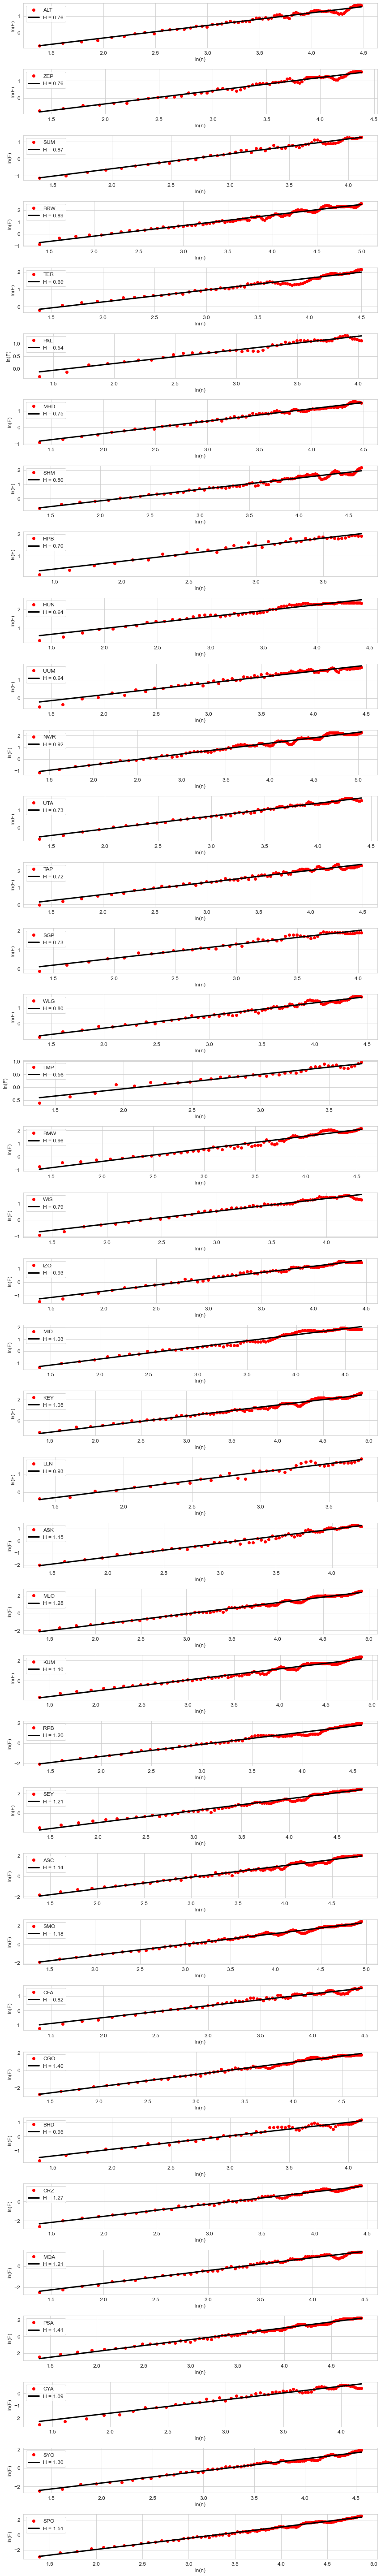

In [91]:
fig = plt.figure(figsize=(12, 80))
plt.rcParams.update({'font.size': 12})

cols = 1
rows = len(co2_data.keys())
for i, st_id in enumerate(info_table.Id.values):
    plt.subplot(rows, cols, i + 1)
    plt.plot(np.log(co2_data[st_id]['n_res']), np.log(co2_data[st_id]['F_res']), 'ro', label=st_id)
    plt.plot(np.log(co2_data[st_id]['n_res']),
             co2_data[st_id]['I_res'] + co2_data[st_id]['H_res'] * np.log(co2_data[st_id]['n_res']),
             'k-', linewidth=3, label='H = {:.2f}'.format(co2_data[st_id]['H_res']))
    plt.ylabel('ln(F)')
    plt.xlabel('ln(n)')
    plt.legend(loc=2)

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()

<font size='4'>
    <ul>
        <li>Black -> H in [0.5, 1.0)</li>
        <li>Magenta -> H in [1.0, 1.5)</li>
        <li>Red -> H in [1.5, 2.0]</li>
    </ul>
</font>

In [92]:
fig, ax = plt.subplots(figsize=(12, 12))
for k in co2_data.keys():
    if co2_data[k]['H_res'] < 1.0:
        c = 'k'
    elif co2_data[k]['H_res'] >= 1.0 and co2_data[k]['H_res'] < 1.5:
        c = 'm'
    else:
        c = 'r'
    plt.scatter(co2_data[k]['longitude'], co2_data[k]['latitude'], c=c, marker='o', s=30)
mplleaflet.display(fig=fig)

/opt/anaconda3/envs/fathon-env/lib/python3.8/site-packages/mplleaflet/mplexporter/exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]
/opt/anaconda3/envs/fathon-env/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<font size='4'>There seems to be a pattern in H along latitude.</font>

# MFDFA

In [93]:
q_list = np.arange(-5, 5, 0.3)

In [94]:
def mf_spect_res(param, lims=None):
    mfdfa_data = co2_data[param]['data'].res.dropna().values
    min_scale = 4
    max_scale = len(mfdfa_data) // 4
    step_scale = 1
    if len(mfdfa_data) > 10 * step_scale:
        mfdfa = fathon.MFDFA(fu.toAggregated(mfdfa_data))
        mfdfa_scales = fu.linRangeByStep(min_scale, max_scale, step_scale)
        n, F = mfdfa.computeFlucVec(mfdfa_scales, q_list)
        if lims is None:
            H, I = mfdfa.fitFlucVec()
        else:
            H, I = mfdfa.fitFlucVec(nStart=lims[0], nEnd=lims[1])
        a, f = mfdfa.computeMultifractalSpectrum()
    else:
        a = np.array([])
        f = np.array([])
        H = np.array([])
    
    return a, f, H

In [95]:
for k in co2_data.keys():
    a, f, hq = mf_spect_res(k)
    co2_data[k]['a_res'] = a
    co2_data[k]['f_res'] = f
    co2_data[k]['hq_res'] = hq

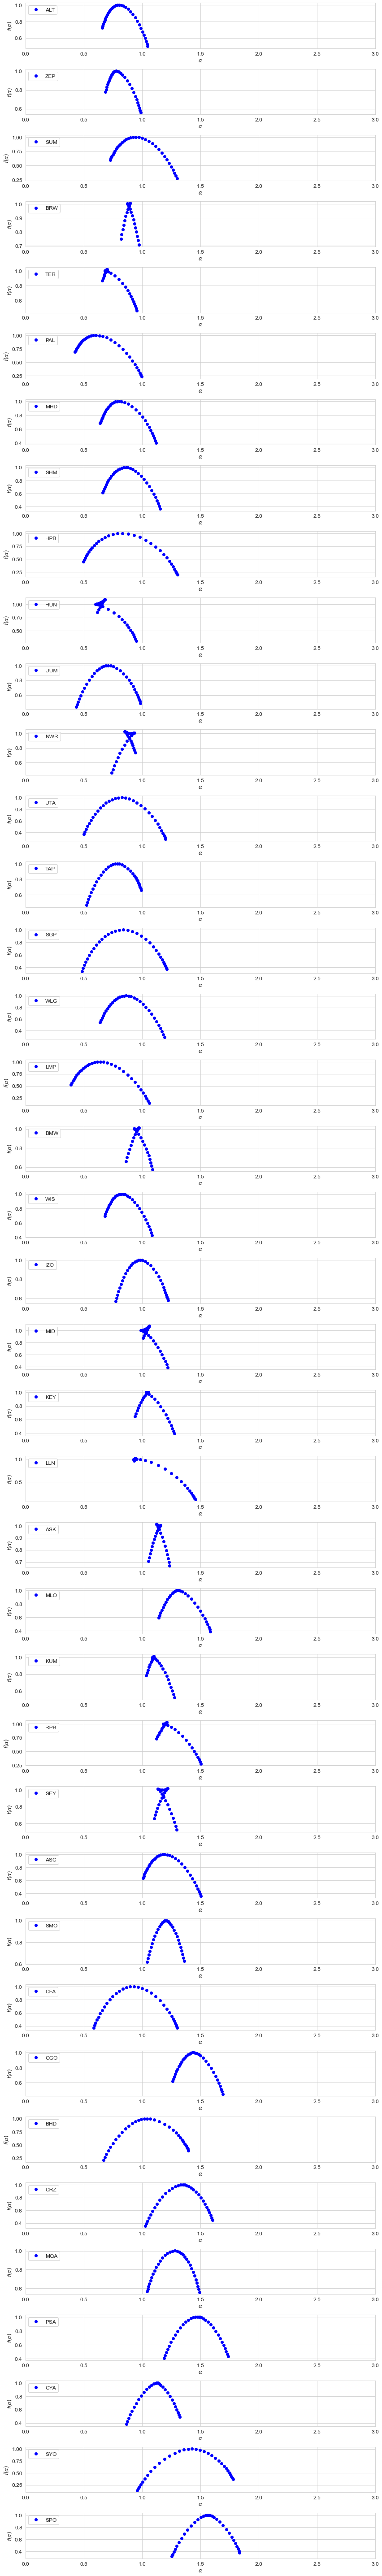

In [96]:
fig = plt.figure(figsize=(12, 80))
plt.rcParams.update({'font.size': 12})

cols = 1
rows = len(co2_data.keys())
for i, st_id in enumerate(info_table.Id.values):
    plt.subplot(rows, cols, i + 1)
    plt.plot(co2_data[st_id]['a_res'], co2_data[st_id]['f_res'], 'bo', label=st_id)
    plt.ylabel('$f(\\alpha)$')
    plt.xlabel('$\\alpha$')
    plt.legend(loc=2)
    plt.xlim(0, 3)

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()

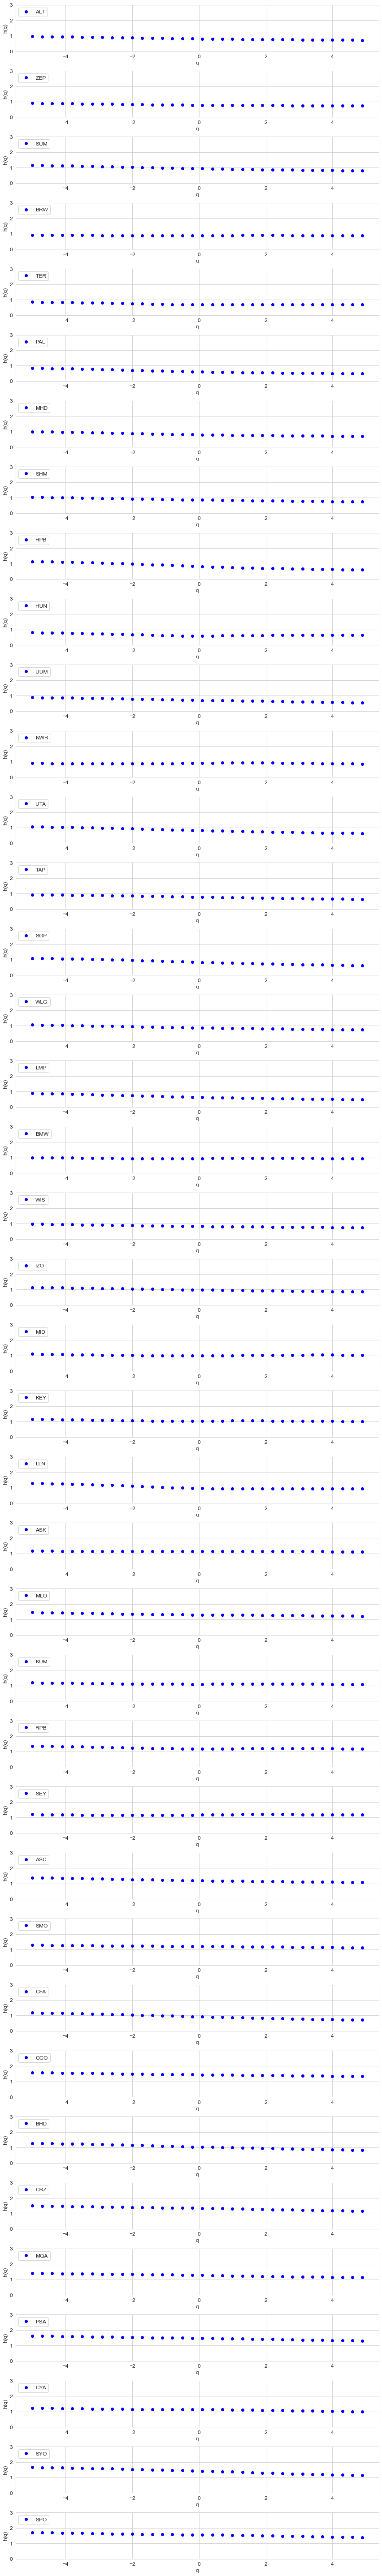

In [97]:
fig = plt.figure(figsize=(12, 80))
plt.rcParams.update({'font.size': 12})

cols = 1
rows = len(co2_data.keys())
for i, st_id in enumerate(info_table.Id.values):
    plt.subplot(rows, cols, i + 1)
    plt.plot(q_list, co2_data[st_id]['hq_res'], 'bo', label=st_id)
    plt.ylabel('h(q)')
    plt.xlabel('q')
    plt.legend(loc=2)
    plt.ylim(0, 3)

plt.subplots_adjust(hspace=0.6)
plt.tight_layout()

<font size='4'>Spectral width and multifractality, instead, does not seem to follow a pattern.</font>